### 1. Imports

In [30]:
import sdv
import pandas as pd

In [31]:
NUM_ROWS = 5110
NUM_EPOCHS = 1000

### 2. Load data

In [32]:
from sdv.datasets.local import _load_data_from_csv

df = _load_data_from_csv(
    filepath='../../data/examples/stroke-real.csv',
    read_csv_parameters={}
    )

In [33]:
df.keys()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### 3. Preprocesing

In [34]:
df['age'] = df['age'].astype('int64')

# use the head method to inspect the first few rows of the data
df.head(3)

id  gender  age  hypertension  heart_disease ever_married  \
0   9046    Male   67             0              1          Yes   
1  51676  Female   61             0              0          Yes   
2  31112    Male   80             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1

In [35]:
df.dtypes

id                     int64
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [36]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(data=df, table_name='strokes')

Auto detected data:



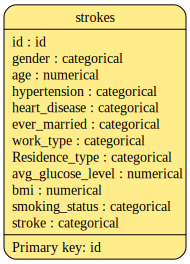

In [37]:
print('Auto detected data:\n')
metadata.visualize()

In [38]:
metadata.update_column(
    column_name='age',
    sdtype='numerical',
    table_name='strokes',
    computer_representation='Int8')

In [39]:
metadata.validate()

In [40]:
metadata.validate_table(data=df, table_name='strokes')

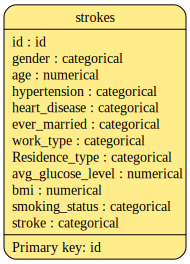

In [41]:
metadata.visualize()

In [42]:
import os
if os.path.exists("metadata.json"):
  os.remove("metadata.json")

metadata.save_to_json('metadata.json')
# in the future, you can reload the metadata object from the file
metadata = Metadata.load_from_json('metadata.json')

### 4. Synthesizers

#### 4.1. GaussianCopulaSynthesizer

In [43]:
from sdv.single_table import GaussianCopulaSynthesizer

gc_synthesizer = GaussianCopulaSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=["es_ES"],
    numerical_distributions={},
    default_distribution='norm'
)

In [44]:
gc_synthesizer.fit(df)

In [45]:
num_no_strokes, num_strokes = df['stroke'].value_counts()
num_new_data = num_no_strokes - num_strokes

In [46]:
new_data = list()
while len(new_data) < num_new_data:
    samples = gc_synthesizer.sample(num_rows=500)
    for sample in samples[samples['stroke'] == 1].values:
        new_data.append(sample.tolist())
        if len(new_data) == num_new_data:
            break

In [47]:
new_data_df = pd.DataFrame(new_data, columns=df.columns)

In [49]:
gc_synthetic_data = pd.concat([df, new_data_df], ignore_index=True)

In [50]:
gc_synthetic_data['stroke'].value_counts()

stroke
1    4861
0    4861
Name: count, dtype: int64

In [51]:
gc_synthetic_data.to_csv(
    '../../data/examples/stroke-gc.csv',
    index=False
)

#### 4.2.CTGANSynthesizer

In [22]:
from sdv.single_table import CTGANSynthesizer

ctgan_synthesizer = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=['es_ES'],
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [23]:
ctgan_synthesizer.fit(df)

Gen. (-1.16) | Discrim. (0.14): 100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


In [24]:
ctgan_synthetic_data = ctgan_synthesizer.sample(num_rows=NUM_ROWS)

In [25]:
ctgan_synthetic_data.to_csv(
    '../../data/examples/stroke-ctgan.csv',
    index=False
)

#### 4.3. TVAESynthesizer

In [26]:
from sdv.single_table import TVAESynthesizer

tvaes_synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [27]:
tvaes_synthesizer.fit(df)

Loss: 3.066: 100%|██████████| 1000/1000 [01:30<00:00, 11.02it/s]


In [28]:
tvaes_synthetic_data = tvaes_synthesizer.sample(num_rows=NUM_ROWS)

In [29]:
tvaes_synthetic_data.to_csv(
    '../../data/examples/stroke-tvaes.csv',
    index=False
)

### 5. Evaluating Real vs. Synthetic Data

#### 5.1. GaussianCopulaSynthesizer

In [52]:
from sdv.evaluation.single_table import run_diagnostic

gc_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=gc_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 764.55it/s]|
Data Validity Score: 99.23%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 261.60it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.62%



In [53]:
from sdv.evaluation.single_table import evaluate_quality

gc_quality_report = evaluate_quality(
    df,
    gc_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 127.33it/s]|
Column Shapes Score: 92.68%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 306.45it/s]|
Column Pair Trends Score: 70.45%

Overall Score (Average): 81.57%



In [54]:
gc_details = gc_quality_report.get_details('Column Pair Trends')
gc_details[gc_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.999260   
16                age                bmi  CorrelationSimilarity  0.997699   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.992683   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.236579  
16          0.333738               0.329136  
49          0.175502               0.160869

In [55]:
gc_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.977464
1                 age  KSComplement  0.958137
2        hypertension  TVComplement  0.996043
3       heart_disease  TVComplement  0.990342
4        ever_married  TVComplement  0.968857
5           work_type  TVComplement  0.952374
6      Residence_type  TVComplement  0.992389
7   avg_glucose_level  KSComplement  0.891470
8                 bmi  KSComplement  0.976235
9      smoking_status  TVComplement  0.943090
10             stroke  TVComplement  0.548728

In [56]:
from sdv.evaluation.single_table import get_column_plot

plot_columns = list(df.columns)
plot_columns.remove("id")

for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=gc_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()

#### 5.2. CTGANSynthesizer

In [35]:
ctgan_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 1184.72it/s]|
Data Validity Score: 99.7%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<?, ?it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.85%



In [36]:
ctgan_quality_report = evaluate_quality(
    df,
    ctgan_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 121.60it/s]|
Column Shapes Score: 94.05%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 158.55it/s]|
Column Pair Trends Score: 85.58%

Overall Score (Average): 89.82%



In [37]:
ctgan_details = ctgan_quality_report.get_details('Column Pair Trends')
ctgan_details[ctgan_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.968354   
16                age                bmi  CorrelationSimilarity  0.946675   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.978298   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.174768  
16          0.333738               0.227088  
49          0.175502               0.132098

In [38]:
ctgan_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.993346
1                 age  KSComplement  0.903523
2        hypertension  TVComplement  0.980039
3       heart_disease  TVComplement  0.959491
4        ever_married  TVComplement  0.962035
5           work_type  TVComplement  0.917025
6      Residence_type  TVComplement  0.898239
7   avg_glucose_level  KSComplement  0.975147
8                 bmi  KSComplement  0.872126
9      smoking_status  TVComplement  0.914286
10             stroke  TVComplement  0.970059

In [39]:
for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=ctgan_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()

#### 5.3. TVAESSynthesizer

In [40]:
tvaes_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=tvaes_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 445.27it/s]|
Data Validity Score: 99.97%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 172.87it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.99%



In [41]:
tvaes_quality_report = evaluate_quality(
    df,
    tvaes_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 131.82it/s]|
Column Shapes Score: 90.09%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 132.06it/s]|
Column Pair Trends Score: 76.26%

Overall Score (Average): 83.18%



In [42]:
tvaes_details = tvaes_quality_report.get_details('Column Pair Trends')
tvaes_details[tvaes_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.932604   
16                age                bmi  CorrelationSimilarity  0.985416   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.947406   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.103268  
16          0.333738               0.304571  
49          0.175502               0.070314

In [43]:
tvaes_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.980039
1                 age  KSComplement  0.885714
2        hypertension  TVComplement  0.919374
3       heart_disease  TVComplement  0.961252
4        ever_married  TVComplement  0.936399
5           work_type  TVComplement  0.748728
6      Residence_type  TVComplement  0.998630
7   avg_glucose_level  KSComplement  0.897456
8                 bmi  KSComplement  0.929963
9      smoking_status  TVComplement  0.687671
10             stroke  TVComplement  0.965166

In [44]:
for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=tvaes_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()